In [208]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [261]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch

import sys
sys.path.insert(0, '../fem')
from heatconduction2d import main, postprocessdata, datasetgenerator
from randompolynomials import *
from GRF import GRF

sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from VarMiON import VarMiON

In [210]:
simparams = {'d': 2,
             'nelems': 32,
             'etype': 'square',
             'btype': 'spline',
             'basisdegree': 1,
             'intdegree': 2,
             'nfemsamples': 2}

p_theta = {'l': 0.4,
        'lowerbound': 0.02,
        'upperbound': 0.99}

p_f = {'l': 0.2,
        'lowerbound': 0.02,
        'upperbound': 0.99}

p_eta = {'l': 0.3,
        'lowerbound': -1,
        'upperbound': 1}

trainingdataparams = {'inputdata': 'grf',
                   'theta': p_theta,
                   'f': p_f,
                   'eta': p_eta,
                   'N_sensornodes': 144,
                   'N_outputnodes': 268,
                   'N_samples': 10000}

params = {}
params['trainingdataparams'] = trainingdataparams
params['simparams'] = simparams

# C = 0.2
# c_theta = C*np.random.uniform(-1, 1, 10)
# c_f = C*np.random.uniform(-1, 1, 10)
# c_etab = C*np.random.uniform(-1, 1, 4)
# c_etat = C*np.random.uniform(-1, 1, 4)
# theta = randompoly2DO3sqr(c_theta)
# f = randompoly2DO3sqr(c_f)
# etab = randompoly1DO3(c_etab)
# etat = randompoly1DO3(c_etat)
# gl = 0
# gr = 0

theta_in = GRF(**simparams, **trainingdataparams, **trainingdataparams['theta'])
f_in = GRF(**simparams, **trainingdataparams, **trainingdataparams['f'])
etab_in = GRF(**simparams, **trainingdataparams, **trainingdataparams['eta'])
etat_in = GRF(**simparams, **trainingdataparams, **trainingdataparams['eta'])
gl_in = 0
gr_in = 0

In [245]:
inputs = {'theta': theta_in,
          'f': f_in,
          'etab': etab_in,
          'etat': etat_in,
          'gl': gl_in,
          'gr': gr_in}

sample = 5
outputs = main(params, inputs, sample, save=False, savedir='../../../trainingdata', label='test')

# generatedataset(params, save=True, savedir='../../../trainingdata', label='test')

optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 7e-16


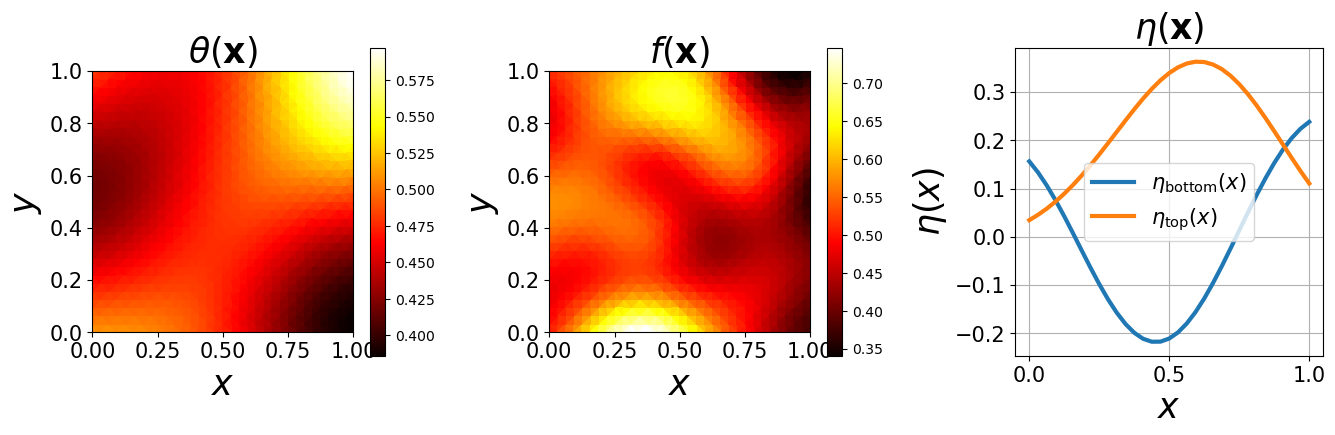

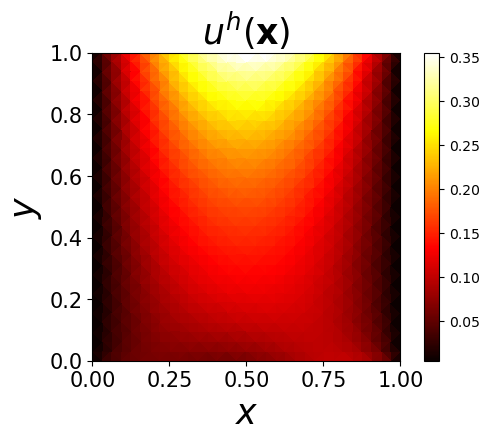

In [246]:
x = outputs['x']
u = outputs['u']
f = outputs['f']
theta = outputs['theta']
etab = outputs['etab']
etat = outputs['etat']

#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 15
size_axeslabels = 25

ax = axs[0]
plot0 = ax.tripcolor(x[:,0], x[:,1], theta, cmap='hot')
ax.set_title(r"$\theta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot0, ax=ax)

ax = axs[1]
plot1 = ax.tripcolor(x[:,0], x[:,1], f, cmap='hot')
ax.set_title(r"$f(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

ax = axs[2]

ax.plot(x[x[:,1]==0,0], etab[x[:,1]==0], label=r'$\eta_\mathrm{bottom}(x)$', linewidth=3)
ax.plot(x[x[:,1]==1,0], etat[x[:,1]==1], label=r'$\eta_\mathrm{top}(x)$', linewidth=3)
ax.set_title(r"$\eta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$\eta(x)$', fontsize=size_axeslabels)
# ax.set_xlim(0,1)
ax.legend(fontsize=15)
ax.set_box_aspect(1)
ax.grid()

# plt.savefig("hc2d_theta_f_eta.svg", bbox_inches='tight')

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.tripcolor(x[:,0], x[:,1], u, cmap='hot')
ax.set_title(r"$u^h(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("hc2d_u.pdf", bbox_inches='tight')

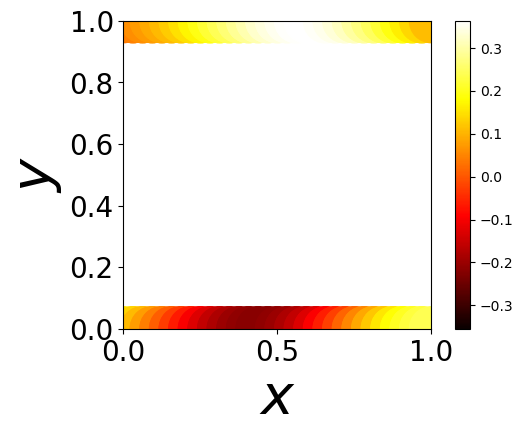

In [501]:
x = outputs['x']
u = outputs['u']
f = outputs['f']
theta = outputs['theta']
etab = outputs['etab']
etat = outputs['etat']

size_title = 25
size_ticklabels = 20
size_axeslabels = 40

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
fig = ax.scatter(x[x[:,1]==0,0], x[x[:,1]==0,1], c=etab[x[:,1]==0], label=r'$\eta_\mathrm{bottom}(x)$', s=1000, cmap='hot', vmin=np.amin(etat), vmax=np.amax(etat))
fig = ax.scatter(x[x[:,1]==1,0], x[x[:,1]==1,1], c=etat[x[:,1]==1], label=r'$\eta_\mathrm{top}(x)$', s=1000, cmap='hot', vmin=np.amin(etat), vmax=np.amax(etat))
# ax.set_title(r"$\eta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
# ax.legend(fontsize=20)
ax.set_box_aspect(1)
plt.colorbar(fig)
# ax.grid()

plt.savefig("eta.svg", bbox_inches='tight', transparent=True)

In [739]:
from VarMiON import VarMiON
from RegularNN import RegularNN

logdir = '../../../nnlogs'
sublogdir = 'grf'
map_location = 'cpu'
model = loadmodelfromlabel(model=RegularNN, label='RegularNN', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
model = loadmodelfromlabel(model=VarMiON, label='allchanges_new', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

data_postprocessed = postprocessdata(params, inputs, sample, outputs)
Theta = data_postprocessed['Theta']
F = data_postprocessed['F']
N = data_postprocessed['N']
x = data_postprocessed['x']
u = data_postprocessed['u']

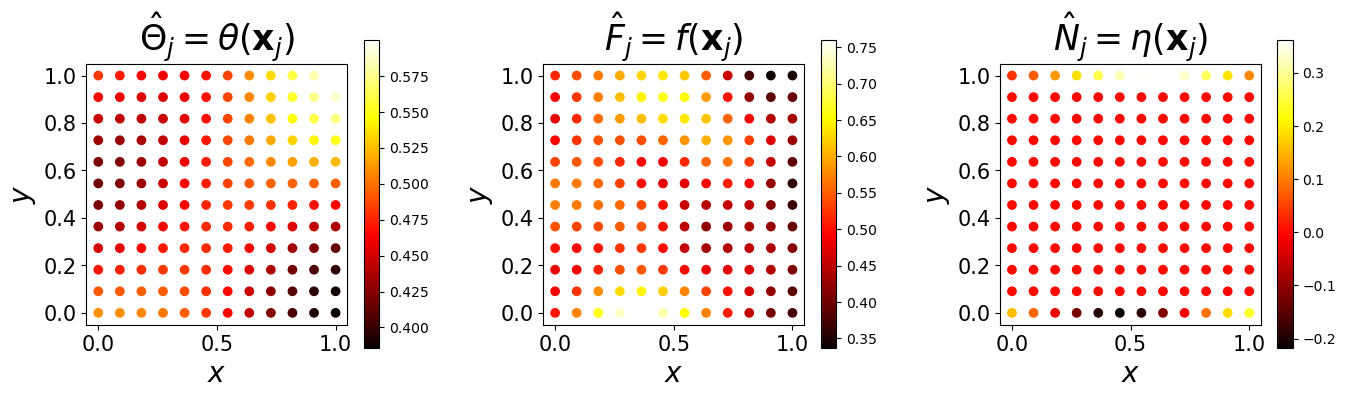

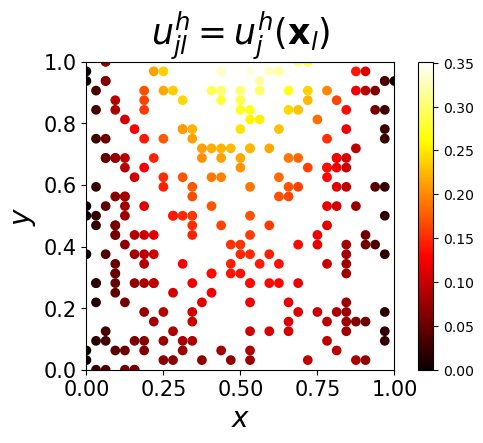

In [337]:
#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 15
size_axeslabels = 20

x_sensor, y_sensor = np.mgrid[0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j, 0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j]

ax = axs[0]
plot0 = ax.scatter(x_sensor, y_sensor, c=Theta.flatten(), cmap='hot')
ax.set_title(r"$\hat{\Theta}_j=\theta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
fig.colorbar(plot0, ax=ax)

ax = axs[1]
plot1 = ax.scatter(x_sensor, y_sensor, c=F.flatten(), cmap='hot')
ax.set_title(r"$\hat{F}_j=f(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

ax = axs[2]
plot2 = ax.scatter(x_sensor, y_sensor, c=N.flatten(), cmap='hot')
ax.set_title(r"$\hat{N}_j=\eta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
fig.colorbar(plot2, ax=ax)

plt.savefig("hc2d_theta_f_eta_postprocessed.pdf", bbox_inches='tight')

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.scatter(x[:,0], x[:,1], c=u, cmap='hot')
ax.set_title(r"$u^h_{jl}=u^h_j(\mathbf{x}_l)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("hc2d_u_postprocessed.pdf", bbox_inches='tight')


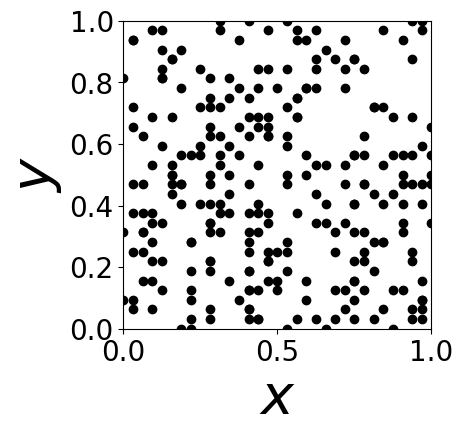

In [476]:
size_title = 25
size_ticklabels = 20
size_axeslabels = 40

x_sensor, y_sensor = np.mgrid[0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j, 0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j]

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.scatter(x[:,0], x[:,1], color='black')#, c=u, cmap='hot')
# ax.set_title(r"$u^h_{jl}=u^h_j(\mathbf{x}_l)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
# plt.colorbar(fig)

plt.savefig("x.svg", bbox_inches='tight', transparent=True)

0.014446242447981535


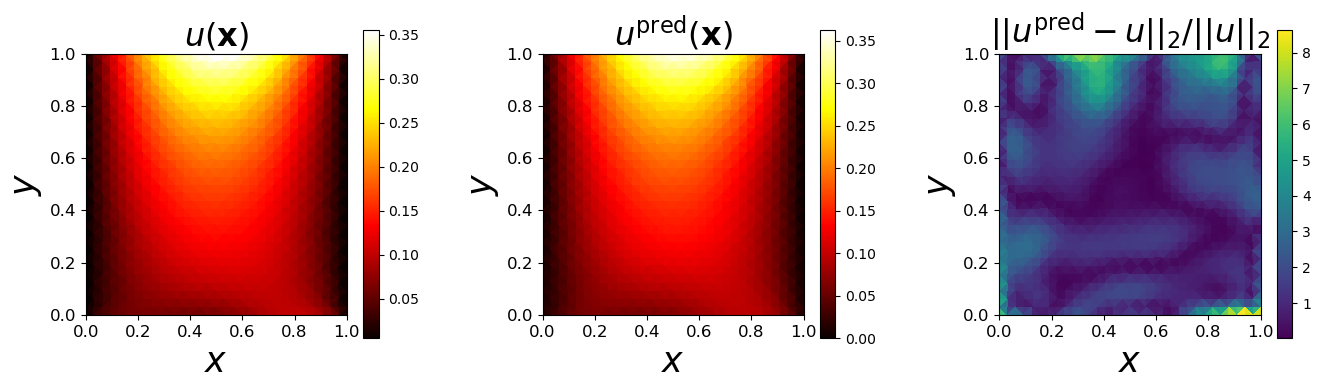

In [740]:
x = outputs['x']
u = outputs['u']
u_hat = model.simforward(Theta, F, N, x)
# u_hat = model.simforward(Theta, F, N, x).detach().numpy()

#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 23
size_ticklabels = 12
size_axeslabels = 25

ax = axs[0]
fig = ax.tripcolor(x[:,0], x[:,1], u, cmap='hot')
ax.set_title(r"$u(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[1]
fig = ax.tripcolor(x[:,0], x[:,1], u_hat, cmap='hot', vmin=np.amin(u), vmax=np.amax(u))
ax.set_title(r"$u^{\mathrm{pred}}(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[2]
fig = ax.tripcolor(x[:,0], x[:,1], 100*np.sqrt((u_hat - u)**2)/np.average(np.sqrt(u**2)))
ax.set_title(r"$||u^{\mathrm{pred}} - {u}||_{2}/||u||_{2}$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("prediction.svg", bbox_inches='tight', transparent=True)

L2 = np.average(np.sqrt((u_hat - u)**2))
L2_scaled = L2/np.average(np.sqrt(u**2))
print(L2_scaled)
# APE = np.abs((u_hat - u)/u)
# APE[APE==np.inf] = np.nan
# MAPE = np.nanmean(APE)
# print('MAPE: '+(str(MAPE)))
# # plt.savefig("nonzeroN.pdf", bbox_inches='tight')

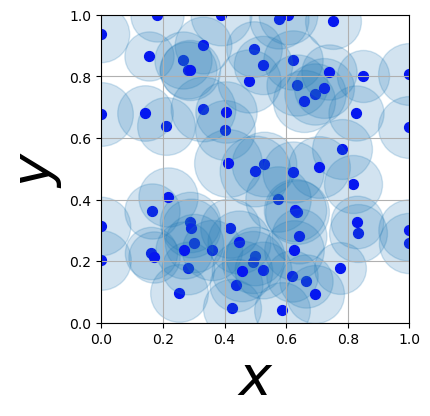

In [738]:
size_title = 25
size_ticklabels = 10
size_axeslabels = 40

mus = model.Trunk.mus.detach().numpy()
sigmas = torch.exp(model.Trunk.log_sigmas).detach().numpy()

x_sensor, y_sensor = np.mgrid[0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j, 0:1:np.sqrt(trainingdataparams['N_sensornodes'])*1j]

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

for i in range(72):
    ax.scatter(mus[i,0], mus[i,1], s=50, alpha=1, color='blue')
    ax.scatter(mus[i,0], mus[i,1], s=10000*sigmas[i], alpha=0.2, color='C0')
# ax.set_title(r"$\hat{\Theta}_j=\theta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
# ax.set_xlim(-0.5,1.5)
# ax.set_ylim(-0.5,1.5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.grid()

# plt.savefig("phis_boundedcenters.svg", bbox_inches='tight')#, transparent=True)

In [734]:
x = torch.linspace(0,1,100)
y = torch.zeros(100)
x = torch.vstack([x,y]).T
phi = model.Trunk(x[:None,None,:]).squeeze()

In [735]:
D = model.NLBranch.forward(torch.ones((1,12,12), dtype=model.dtype)).squeeze()

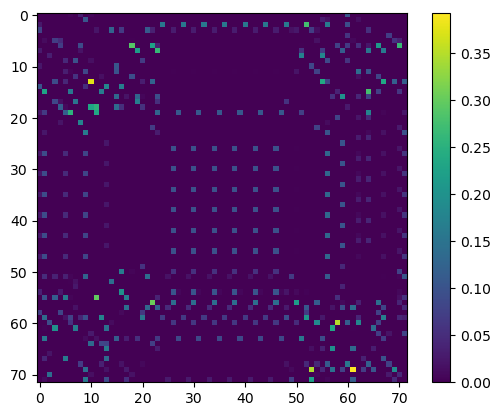

In [736]:
plt.imshow(D.detach().numpy())
plt.colorbar()

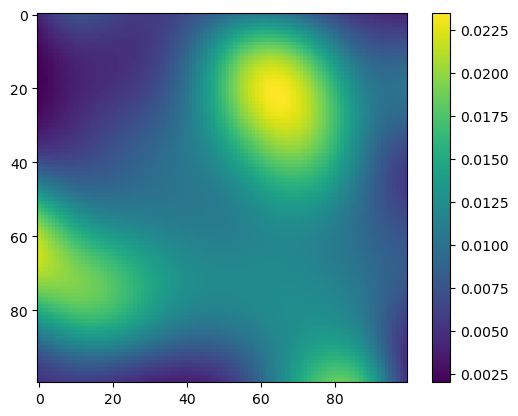

In [737]:
G = torch.einsum('mi,ij,nj->mn', phi, D, phi).detach().numpy()
plt.imshow(G)
plt.colorbar()

### Test score

In [582]:
#Test dataset
N_samples = 1000
Theta_test = torch.tensor(np.load('../../../trainingdata/grf/test/Theta.npy'))[:N_samples]
F_test = torch.tensor(np.load('../../../trainingdata/grf/test/F.npy'))[:N_samples]
N_test = torch.tensor(np.load('../../../trainingdata/grf/test/N.npy'))[:N_samples]
x_test = torch.tensor(np.load('../../../trainingdata/grf/test/x.npy'))[:N_samples]
u_test = torch.tensor(np.load('../../../trainingdata/grf/test/u.npy'))[:N_samples]

In [741]:
from VarMiON import VarMiON
from RegularNN import RegularNN

model = VarMiON
logdir = '../../../nnlogs'
sublogdir = 'grf'
map_location = 'cpu'

noLBbias = loadmodelfromlabel(model=model, label='noLBbias', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
noNLBoutputactivation = loadmodelfromlabel(model=model, label='noNLBoutputactivation', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
PosDefSymD = loadmodelfromlabel(model=model, label='SymPosDefD', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
PosDefSymD_noNLBoutputactivation = loadmodelfromlabel(model=model, label='SymPosDefD_noNLBoutputactivation', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
scale_invariant = loadmodelfromlabel(model=model, label='scale_invariant', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
normalized_basis = loadmodelfromlabel(model=model, label='normalized_basis', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
onedivtheta = loadmodelfromlabel(model=model, label='1divtheta', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
tanhshrink = loadmodelfromlabel(model=model, label='tanhshrink', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
SymPosDefD_tanhshrink = loadmodelfromlabel(model=model, label='SymPosDefD_tanhshrink', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
boundedcenters = loadmodelfromlabel(model=model, label='boundedcenters', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
allchanges = loadmodelfromlabel(model=model, label='allchanges_new', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
VarMiON = loadmodelfromlabel(model=model, label='VarMiON', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
RegularNN = loadmodelfromlabel(model=RegularNN, label='RegularNN', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

modeldict = {'Naive NN': RegularNN,
             'VarMiON': VarMiON,
             # 'No bias': noLBbias,
             # 'noNLBoutputactivation': noNLBoutputactivation,
             # 'SymPosDefD': PosDefSymD,
             # 'SymPosDefD, noNLBoutputactivation': PosDefSymD_noNLBoutputactivation,
             # 'Scale invariant': scale_invariant,
             # 'Normalized basis': normalized_basis,
             # 'SymPosDefD_tanhshrink': SymPosDefD_tanhshrink,
             # 'tanhshrink': tanhshrink,
             # '1divtheta': onedivtheta,
             # 'boundedcenters': boundedcenters}
             'Extended VarMiON': allchanges}

In [742]:
# #old
# size_title = 20
# size_ticklabels = 12
# size_axeslabels = 20

# fig, ax = plt.subplots(1,1, figsize=(6, 4))
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

# colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8']

# i=0
# for model in modeldict:
#     u_hat = modeldict[str(model)].forward(Theta_test, F_test, N_test, x_test).detach().numpy()
#     APE = np.abs((u_hat - u_test.detach().numpy())/u_test.detach().numpy())
#     APE = APE[APE!=np.inf]
#     MAPE = np.average(APE)
#     sigma = np.std(APE)
#     # ax.hist(100*APE, bins=np.linspace(0,10,100), density=True, alpha=0.5, linewidth=1, color=colors[i], histtype='bar')
#     ax.hist(APE, bins=np.logspace(-9,5,100), density=False, alpha=0.5, linewidth=1, color=colors[i], histtype='bar')
#     ax.axvline(MAPE,0,1, linewidth=2, color=colors[i], label=r'$\mu=$'+str(np.around(MAPE, 3))+r', $\sigma=$'+str(np.around(sigma, 3))+', '+str(model))
#     # ax.axvline(100*MAPE,0,1, linewidth=2, color=colors[i], label=str(np.around(100*MAPE, 2))+'% $\pm$'+str(np.around(sigma, 2))+'%, '+str(model))
#     i+=1
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(fontsize=12)
# ax.tick_params(axis='both', labelsize=size_ticklabels)
# # ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$|(\hat{u} - u^h)/u^h|$', fontsize=size_axeslabels)
# # ax.set_xlabel(r'Val. error in %', fontsize=size_axeslabels)
# ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
# # ax.grid()

# # plt.savefig("nodesavg.svg", bbox_inches='tight')

In [743]:
# size_title = 20
# size_ticklabels = 12
# size_axeslabels = 20

# fig, ax = plt.subplots(1,1, figsize=(6, 4))
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

# colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8']

# i=0
# for model in modeldict:
#     u_hat = modeldict[str(model)].forward(Theta_test, F_test, N_test, x_test).detach().numpy()
#     L2 = np.average(np.sqrt((u_hat - u_test.detach().numpy())**2), axis=-1)
#     L2_scaled = L2/np.average(np.sqrt((u_test.detach().numpy())**2), axis=-1)
#     # APE[np.abs(u_test)<1e-4] = np.nan
#     MAPE = np.nanmean(APE, axis=-1)
#     L2_scaled_avg = np.average(L2_scaled)
#     sigma = np.std(L2_scaled)
#     # ax.hist(100*APE, bins=np.linspace(0,10,100), density=True, alpha=0.5, linewidth=1, color=colors[i], histtype='bar')
#     ax.hist(L2_scaled, bins=np.logspace(-3,2,100), density=False, alpha=0.5, linewidth=1, color=colors[i], histtype='bar')
#     ax.axvline(L2_scaled_avg, 0, 1, linewidth=2, color=colors[i], label=r'$\mu=$'+str(np.around(L2_scaled_avg, 3))+r', $\sigma=$'+str(np.around(sigma, 3))+', '+str(model))
#     # ax.axvline(100*MAPE,0,1, linewidth=2, color=colors[i], label=str(np.around(100*MAPE, 2))+'% $\pm$'+str(np.around(sigma, 2))+'%, '+str(model))
#     i+=1
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(fontsize=12)
# ax.tick_params(axis='both', labelsize=size_ticklabels)
# # ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$\langle|(\hat{u} - u^h)/u^h|\rangle$', fontsize=size_axeslabels)
# # ax.set_xlabel(r'Val. error in %', fontsize=size_axeslabels)
# ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
# # ax.grid()

# # plt.savefig("grftest_nosmallu.svg", bbox_inches='tight')

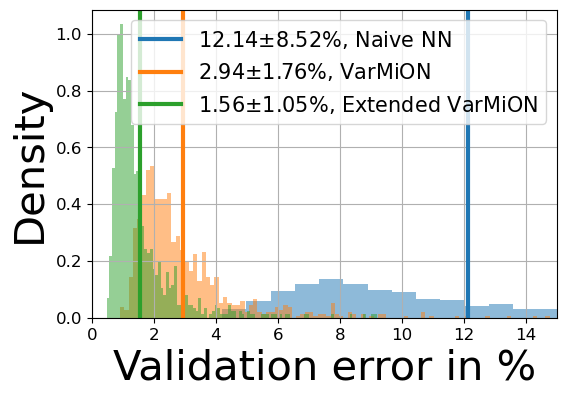

In [749]:
size_title = 20
size_ticklabels = 12
size_axeslabels = 30

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

i=0
for model in modeldict:
    u_hat = modeldict[str(model)].forward(Theta_test, F_test, N_test, x_test).detach().numpy()
    L2 = np.average(np.sqrt((u_hat - u_test.detach().numpy())**2), axis=-1)
    L2_scaled = L2/np.average(np.sqrt((u_test.detach().numpy())**2), axis=-1)
    # APE[np.abs(u_test)<1e-4] = np.nan
    MAPE = np.nanmean(APE, axis=-1)
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(100*L2_scaled, bins=100, density=True, alpha=0.5, linewidth=1, color=colors[i], histtype='bar')
    ax.axvline(100*L2_scaled_avg, 0, 1, linewidth=3, color=colors[i], label=str(np.around(100*L2_scaled_avg, 2))+r'$\pm$'+str(np.around(100*sigma, 2))+'%, '+str(model))
    i+=1
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0,15)
ax.legend(fontsize=15)
ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$\langle|(\hat{u} - u^h)/u^h|\rangle$', fontsize=size_axeslabels)
ax.set_xlabel(r'Validation error in %', fontsize=size_axeslabels)
ax.set_ylabel(r'Density', fontsize=size_axeslabels)
ax.grid()
# plt.savefig("naiveNN.pdf", bbox_inches='tight')#, transparent=True)

### Positive definiteness

In [205]:
from VarMiON import VarMiON

model = VarMiON
logdir = '../../../nnlogs'
sublogdir = 'poly_nonzeroN'
map_location = 'cpu'
PosDefSymD = loadmodelfromlabel(model=VarMiON, label='PosDefSymD_tril', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
PosDefSymD_noNLBoutputReLU = loadmodelfromlabel(model=VarMiON, label='PosDefSymD_noNLBoutputReLU_tril', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
VarMiON = loadmodelfromlabel(model=VarMiON, label='VarMiON', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

modeldict = {'VarMiON': VarMiON,
    # 'SymPosDefD': PosDefSymD,
            'SymPosDefD, no output ReLU': PosDefSymD_noNLBoutputReLU}

In [206]:
# Theta_test = torch.rand((100,12,12),dtype=torch.double)
# D = model.NLBranch.forward(Theta_test)
# v = torch.normal(0,1,(100,1))
# # v = torch.zeros((100,1))
# pd = torch.einsum('ni,nij,nj->n',v,D,v).detach().numpy()

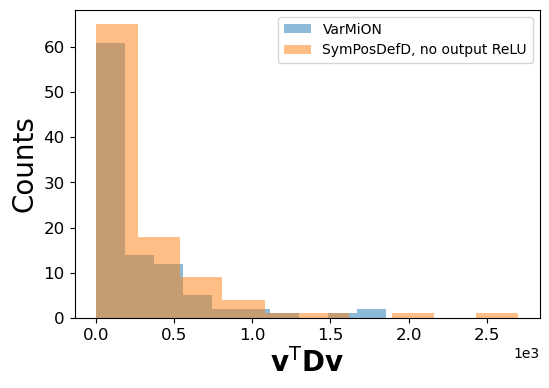

In [207]:
Theta_test = torch.normal(0,1,(100,12,12),dtype=torch.double)
v = torch.normal(0,1,(100,1))
# v = torch.zeros((100,1))
size_title = 20
size_ticklabels = 12
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8']

i=0
for model in modeldict:
    D = modeldict[str(model)].NLBranch.forward(Theta_test)
    pd = torch.einsum('ni,nij,nj->n',v,D,v).detach().numpy()
    ax.hist(pd, label=str(model), alpha=0.5)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(fontsize=10)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$\mathbf{v}^{\mathrm{T}}\mathbf{D}\mathbf{v}$', fontsize=size_axeslabels)
# ax.set_xlabel(r'Val. error in %', fontsize=size_axeslabels)
ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
# ax.grid()

plt.savefig("positivedefiniteness_new.svg", bbox_inches='tight')

### Scale invariance

In [251]:
labda = torch.rand(100,1,1, dtype=torch.double)

Theta_test = torch.rand((100,12,12),dtype=torch.double)
v = torch.normal(0,1,(100,1))
# v = torch.zeros((100,1))
size_title = 20
size_ticklabels = 12
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8']

i=0
for model in modeldict:
    D = modeldict[str(model)].NLBranch.forward(Theta_test)
    print(modeldict[str(model)].params['hparams']['Cholesky'])
    pd = torch.einsum('ni,nij,nj->n',v,D,v).detach().numpy()
    ax.hist(pd, label=str(model), alpha=0.5)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(fontsize=10)
ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$\mathbf{v}^{\mathrm{T}}\mathbf{D}\mathbf{v}$', fontsize=size_axeslabels)
# ax.set_xlabel(r'Val. error in %', fontsize=size_axeslabels)
# ax.set_ylabel(r'Counts', fontsize=size_axeslabels)
# ax.grid()

# plt.savefig("positivedefiniteness.pdf", bbox_inches='tight')